In [2]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

print(schema)

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

In [3]:
df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:25000/nam_tiny_copy.tdv')

In [4]:
%%time
# warmup1
# Creating an SQL 'table'
df.createOrReplaceTempView("TEMP_DF")

# Let's get all the friction velocity surface values:
friction_velocity_surface_min = spark.sql("SELECT MIN(friction_velocity_surface) FROM TEMP_DF").collect()
friction_velocity_surface_max = spark.sql("SELECT MAX(friction_velocity_surface) FROM TEMP_DF").collect()
friction_velocity_surface_avg = spark.sql("SELECT AVG(friction_velocity_surface) FROM TEMP_DF").collect()

print(friction_velocity_surface_min)
print(friction_velocity_surface_max)
print(friction_velocity_surface_avg)

[Row(min(friction_velocity_surface)=0.02586597390472889)]
[Row(max(friction_velocity_surface)=0.8758659958839417)]
[Row(avg(friction_velocity_surface)=0.3311159858293831)]
CPU times: user 5.23 ms, sys: 6.04 ms, total: 11.3 ms
Wall time: 12.5 s


In [5]:
%%time
# warmup2
maxtemp = spark.sql("SELECT temperature_surface, Timestamp/1000, Geohash FROM TEMP_DF where temperature_surface in (SELECT MAX(temperature_surface) FROM TEMP_DF)").collect()
print(maxtemp)

[Row(temperature_surface=306.4980163574219, (CAST(Timestamp AS DOUBLE) / CAST(1000 AS DOUBLE))=1426377600.0, Geohash='9qd23ynghrrz')]
CPU times: user 7.87 ms, sys: 3.37 ms, total: 11.2 ms
Wall time: 1min 35s


In [5]:
%%time
# warmup 3
snowysurface = spark.sql("Select Geohash from TEMP_DF where Geohash not in (Select distinct(Geohash) from TEMP_DF where categorical_snow_yes1_no0_surface = 0)").collect()
print(snowysurface)

[Row(Geohash='f2w29r4werxb'), Row(Geohash='fccz22w4fytb'), Row(Geohash='c1nuq5290jup'), Row(Geohash='f2d5v1jeyp7z'), Row(Geohash='c6s64488ws80'), Row(Geohash='f2fh6jpdgv5b')]
CPU times: user 7.01 ms, sys: 3.23 ms, total: 10.2 ms
Wall time: 3.96 s


In [12]:
%%time
# isolated snowy peak
snow_covered_locations = df[df.categorical_snow_yes1_no0_surface == 1].collect()

for row in snow_covered_locations:
    is_snowy = False

    neighbors = geohash.neighbors(row.Geohash)

    for s in neighbors:
        print("neighbor " + s)
        count = spark.sql(f"select count(*) as cc from nam_tiny where Geohash = '{s}'\
                      and categorical_snow_yes1_no0_surface = 0 group by Geohash having count(*) > 0").collect()
        if(len(count) > 0):
            issnowy = True
            break
    
    if (is_snowy == False):
        print("strangely snowy place found")
        print("cold place " + row.Geohash)

NameError: name 'geohash' is not defined

In [11]:
%%time
# Travel Startup
relative_humidity_zerodegc_isotherm = 45
min_surface_wind_gust_surface = 1.67
max_surface_wind_gust_surface = 3.1
temperature_surface = 77
total_cloud_cover_entire_atmosphere = 60 
# Grand canyon 9qrhf6btbt3jevhn
# Panhandle san francisco 9q8yvs4t
# New york dr5regw2z6y
# Fresno 9qd23ynghrrz

traveldata = spark.sql("SELECT  substring(Geohash, 0, 5) as region, MONTH(FROM_UNIXTIME(Timestamp/1000)) as month, AVG(temperature_surface) as temperature, AVG(relative_humidity_zerodegc_isotherm) as humdity, AVG(surface_wind_gust_surface) as windspeed, AVG(total_cloud_cover_entire_atmosphere) as cloudcover FROM TEMP_DF WHERE Geohash like '9qd23%' or Geohash like 'dr5re%' or Geohash like '9q8yv%' or Geohash like '9qrhf%'  group by MONTH(FROM_UNIXTIME(Timestamp/1000)), substring(Geohash, 0, 5)").collect()
for row in traveldata:
    isgood = True
    if(row.temperature < (temperature_surface - (temperature_surface * .1)) or  row.temperature > (temperature_surface + (temperature_surface * .1))):
        isgood = False
    if(row.humdity < (relative_humidity_zerodegc_isotherm - (relative_humidity_zerodegc_isotherm * .1)) or  row.humdity > (relative_humidity_zerodegc_isotherm + (relative_humidity_zerodegc_isotherm * .1))):
        isgood = False
    if(row.windspeed < min_surface_wind_gust_surface or  row.windspeed > max_surface_wind_gust_surface):
        isgood = False
    if(row.cloudcover < (total_cloud_cover_entire_atmosphere - (total_cloud_cover_entire_atmosphere * .1)) or  row.cloudcover > (total_cloud_cover_entire_atmosphere + (total_cloud_cover_entire_atmosphere * .1))):
        isgood = False
    if(isgood == True):
        print(f"{row.region} {row.month}")
        

CPU times: user 4.89 ms, sys: 3.38 ms, total: 8.28 ms
Wall time: 3.76 s


In [9]:
%%time
# Machine learning
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    ["geopotential_height_lltw", 
     "upward_long_wave_rad_flux_surface", 
     "albedo_surface", 
     "downward_long_wave_rad_flux_surface",
     "plant_canopy_surface_water_surface",
     "geopotential_height_zerodegc_isotherm",
     "temperature_surface",
     "snow_depth_surface"
    ],
    "snow_cover_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3975.03125,424.9...|  0.0|
|[-3088.21875,234....|  0.0|
|[2515.78125,430.9...|  0.0|
|[136.53125,314.05...|  0.0|
|[2437.03125,427.0...|  0.0|
|[3206.28125,445.9...|  0.0|
|[4.28125,303.1810...|  0.0|
|[3474.53125,422.3...|  0.0|
|[3126.03125,402.8...|  0.0|
|[3939.78125,445.3...|  0.0|
|[2788.28125,391.9...|  0.0|
|[-472.96875,291.5...|  0.0|
|[3284.53125,445.0...|  0.0|
|[2062.28125,377.4...|  0.0|
|[2318.03125,405.3...|  0.0|
|[3072.03125,344.6...|  0.0|
|[315.28125,315.68...|  0.0|
|[3568.28125,438.8...|  0.0|
|[3369.28125,448.3...|  0.0|
|[2902.53125,332.3...|  0.0|
+--------------------+-----+
only showing top 20 rows

CPU times: user 12.9 ms, sys: 2.22 ms, total: 15.2 ms
Wall time: 266 ms


In [10]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0995346


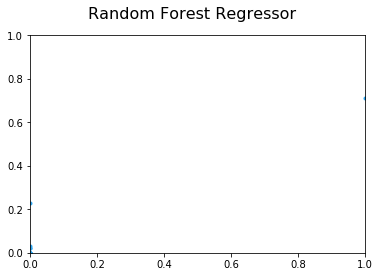

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()